In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
import pywt

In [5]:
import os
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt

In [22]:
directory = "C:\\Users\\Rohit\\Desktop\\LAB WORK(IMP)\\EE610\\Assignment\\EE610-Image-Processing\\Assignment2\\BDS500\\train\\"
img_train = []
ids_img_train = []
for filename in os.listdir(directory):
    ids_img_train.append(int(filename[:-4]))
    img_train.append(cv2.imread(directory + filename))

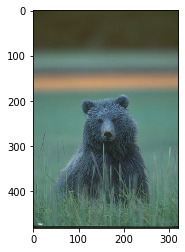

In [23]:
plt.imshow(img_train[1])
plt.show()

In [24]:
x = tf.convert_to_tensor(img_train[0])

In [26]:
x[:, :, 1]

<tf.Tensor: shape=(321, 481), dtype=uint8, numpy=
array([[118, 122, 122, ...,  32,  29,  30],
       [115, 116, 116, ...,  31,  32,  30],
       [125, 123, 122, ...,  28,  30,  31],
       ...,
       [ 69,  68,  72, ...,  43,  44,  38],
       [ 73,  75,  78, ...,  45,  40,  38],
       [ 79,  80,  73, ...,  43,  39,  36]], dtype=uint8)>

In [8]:
coeffs = pywt.dwt2(img_train[1], 'haar')
cA, (cH, cV, cD) = coeffs

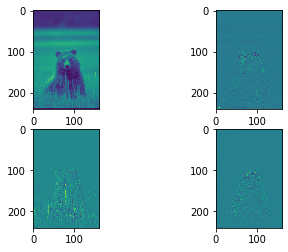

In [9]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(cA)#og image
axarr[0,1].imshow(cH)#horizontal components
axarr[1,0].imshow(cV)#horizontal components
axarr[1,1].imshow(cD)#high frequency components.

In [10]:
class DWT(keras.layers.Layer):
    def __init__(self):
        super(DWT, self).__init__()
    def call(self, x):
        cA, (cH, cV, cD) = pywt.dwt2(x, 'haar')
        return tf.convert_to_tensor(cA), tf.convert_to_tensor(cH), tf.convert_to_tensor(cV), tf.convert_to_tensor(cD)

In [11]:
dwt = DWT()

In [12]:
b = dwt(img_train[20]);

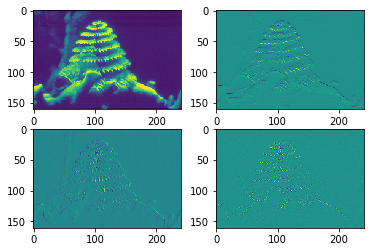

In [13]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(b[0])#og image
axarr[0,1].imshow(b[1])#horizontal components
axarr[1,0].imshow(b[2])#horizontal components
axarr[1,1].imshow(b[3])#high frequency components.

In [14]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape=(256,256,1)):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [16]:
model = build_unet()

In [18]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [51]:
class Linear(keras.layers.Layer):
    def __init__(self, units=32, input_dim=32):
        super(Linear, self).__init__()#makes compatibility with other classes easier
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(input_dim, units), dtype="float32"),
            trainable=False,
        )#setting trainable to false so as not to include it in the back prop
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(
            initial_value=b_init(shape=(units,), dtype="float32"), trainable=False
        )#setting trainable to false so as not to include it in the back prop

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

In [52]:
x = tf.ones((2, 2))
linear_layer = Linear(4, 2)
y = linear_layer(x)
print(y)

tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.06674977  0.06828572  0.06210998 -0.03083389]
 [ 0.06674977  0.06828572  0.06210998 -0.03083389]], shape=(2, 4), dtype=float32)


In [53]:
linear_layer.w

<tf.Variable 'Variable:0' shape=(2, 4) dtype=float32, numpy=
array([[ 0.05728893,  0.01801976,  0.04703547,  0.002133  ],
       [ 0.00946085,  0.05026596,  0.0150745 , -0.03296689]],
      dtype=float32)>

In [54]:
linear_layer.b

<tf.Variable 'Variable:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>

In [15]:
class fname:
    def __init__(self, name, lname):
        self.name = name
        self.lname = lname
    def say_hi(self):
        print('Hello, my name is', self.name, self.lname)


In [16]:
m = fname("NN", "MM")

In [19]:
m.lname

'MM'